# Imports

In [36]:
# Copyright (c) 2022-2024 Mitsubishi Electric Research Laboratories (MERL).
#
# SPDX-License-Identifier: AGPL-3.0-or-later

# import modules
import pandas as pd
import numpy as np
from pylab import * 
import seaborn as sns
import sqlite3


sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (8,5.5)
filepath = "../"

# Section 5.2 - Size of Linearization

In [19]:
# Connect to the SQLite database
conn = sqlite3.connect('../results/experiments.db')

# Define your SQL query with JOIN and WHERE clauses
sql_query = """
    SELECT Instance.*, BaseLinearization.ub, BaseLinearization.linearization, MinLinearization.warm_start as MinLinWarm, BBLinearization.warm_start as BBWarm, BBLinearization.solver as BBSolver, MinLinearization.solver as MinLinSolver
    FROM BaseLinearization
    LEFT JOIN MinLinearization ON MinLinearization.id = BaseLinearization.id
    LEFT JOIN BBLinearization ON BBLinearization.id = BaseLinearization.id
    JOIN Instance ON Instance.id = BaseLinearization.instance_id
"""

# Execute the SQL query with parameters and load the result into a pandas DataFrame
df = pd.read_sql_query(sql_query, conn)

# Remove rows where column warm_start is equal to 0
df = df[df['MinLinWarm'] != 0]    
del df['MinLinWarm']

df = df[df['BBWarm'] != 0]    
del df['BBWarm']


# Filter rows where linearization equals 'Seq' and calculate size for these rows
seq_sizes = df[df['linearization'] == 'sequential'][["name","type","ub"]]

# Merge the size values for linearization = 'Seq' with the original DataFrame
df = df.merge(seq_sizes, on="name", suffixes=('', '_seq'))
del df['type_seq']
df.rename(columns = {'ub_seq': 'gain',   "instance_type":"type"}, inplace = True) 
df["gain"] = 100.0*(1.0-df["ub"]/df["gain"])

conn.close()

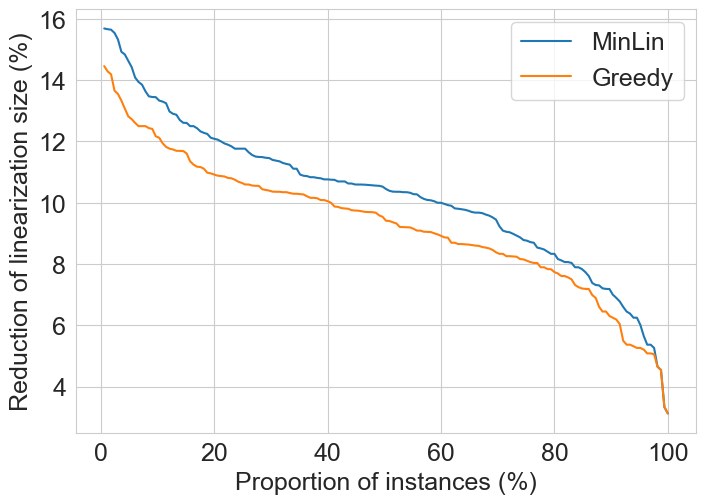

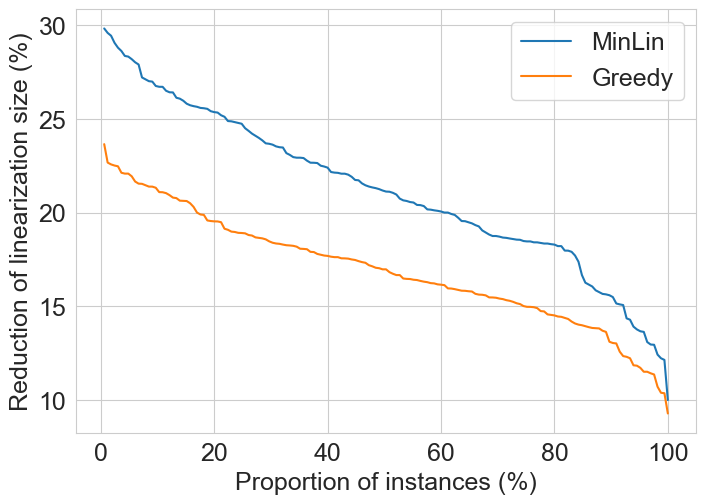

In [20]:
def linearization_size(df,instance):
    if len(df) == 0:
        return

    mlp_x = sorted(df[df["linearization"] == "greedy"]["gain"].to_list(),reverse=True)
    a = df[df["linearization"] == "greedy"]["name"].to_list()
    b = df[ (df["linearization"] == "minlin") & (df["MinLinSolver"] == "GUROBI11")  ]["name"].to_list()

    mlp_y = sorted(df[ (df["linearization"] == "minlin") & (df["MinLinSolver"] == "GUROBI11")  ]["gain"].to_list(),reverse=True)
    base = range(1,len(mlp_x)+1)
    base = [100.0*x/len(mlp_x) for x in base]

    plt.plot([100.0*x/len(mlp_y) for x in range(1,len(mlp_y)+1)],mlp_y,label="MinLin")
    plt.plot([100.0*x/len(mlp_x) for x in range(1,len(mlp_x)+1)],mlp_x,label="Greedy")


    plt.gray()
    plt.legend(loc='lower right')#, bbox_to_anchor=(1, 0.9))
    plt.ylabel('Reduction of linearization size (%)')
    plt.xlabel("Proportion of instances (%)")
    plt.legend(loc='upper right')
    plt.savefig("../results/Linearization_size_"+instance+".png",bbox_inches="tight")
    plt.show()

instance_types = ["mult_d_3","mult_d_4"]
for instance in instance_types:
    linearization_size(df[df["type"]==instance],instance)

# Section 5.3 - LP Bounds

In [21]:
# Connect to the SQLite database
conn = sqlite3.connect('../results/experiments.db')

sql_query = """
    SELECT Instance.*, LP.obj, BaseLinearization.linearization, MinLinearization.warm_start as MinLinWarm, BBLinearization.warm_start as BBWarm, BBLinearization.solver as BBSolver, MinLinearization.solver as MinLinSolver
    FROM LP
    JOIN BaseLinearization ON LP.id = BaseLinearization.id
    JOIN Instance ON BaseLinearization.instance_id = Instance.id
    LEFT JOIN MinLinearization ON MinLinearization.id = BaseLinearization.id
    LEFT JOIN BBLinearization ON BBLinearization.id = BaseLinearization.id
"""

# Execute the SQL query with parameters and load the result into a pandas DataFrame
df = pd.read_sql_query(sql_query, conn)

# Filter rows where linearization equals 'Seq' and calculate size for these rows
full_bound = df[df['linearization'] == 'full'][["name","obj"]]

# Merge the size values for linearization = 'Seq' with the original DataFrame
df = df.merge(full_bound, on="name", suffixes=('', '_seq'))
df.rename(columns = {'obj_seq': 'gap'}, inplace = True) 

df["gap"] = 100*(df["obj"]/df["gap"] - 1.0)
conn.close()

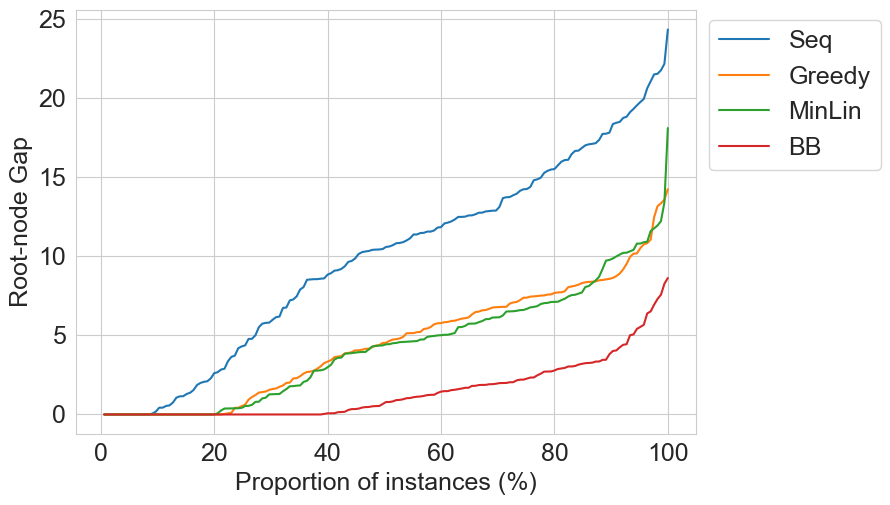

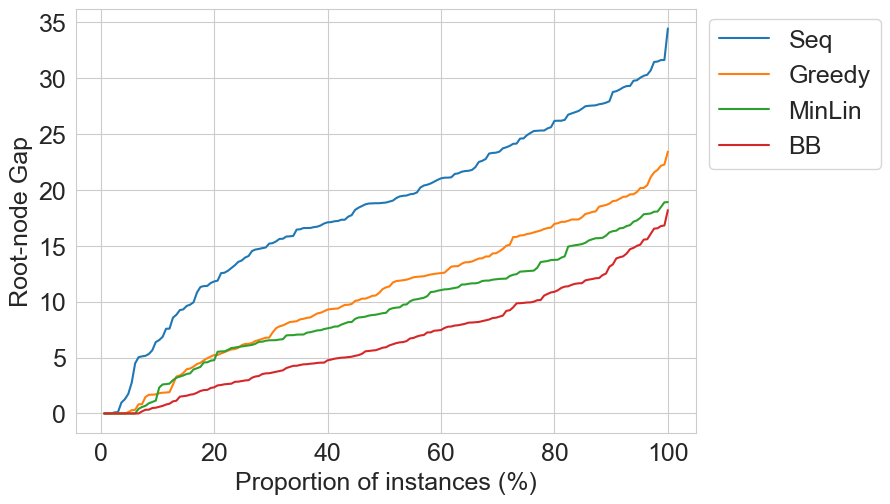

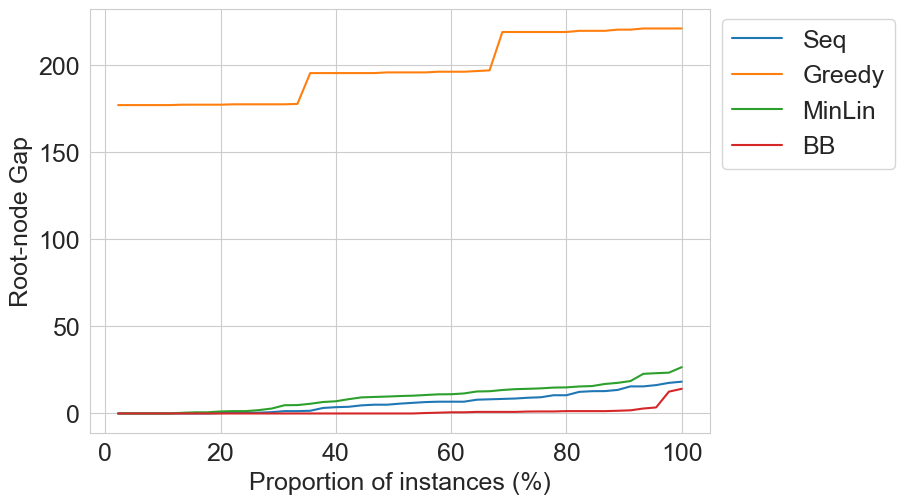

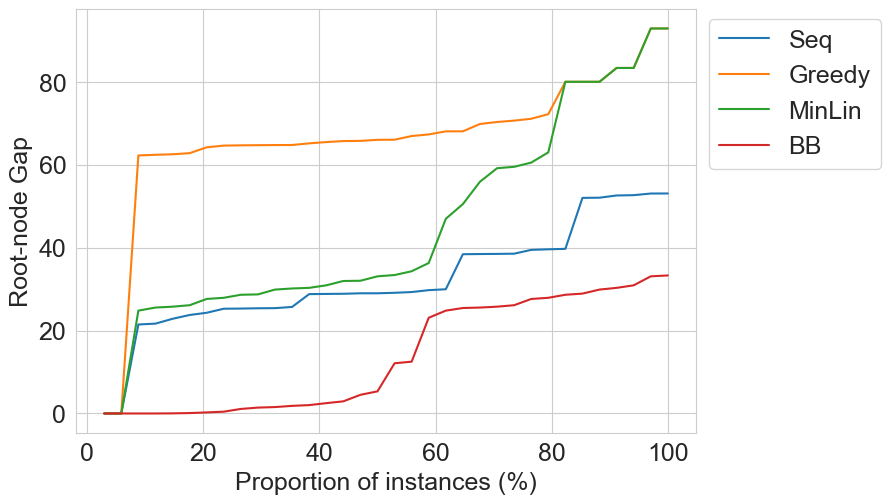

In [22]:
def gap_plot(df,instance):

  if len(df) == 0:
    return
  
  lp_gap_filtered =  ["sequential","greedy","minlin","bestbnd"]
  for alg in lp_gap_filtered:
    values = sorted(df[df["linearization"]==alg]["gap"].to_list(),reverse=False) 
    base = range(1,len(values)+1)
    base = [100.0*x/len(values) for x in base]  
    plt.plot(base,values)

  plt.legend(["Seq","Greedy","MinLin","BB"],loc='center left', bbox_to_anchor=(1, 0.8))
  plt.ylabel('Root-node Gap')
  plt.xlabel("Proportion of instances (%)")
  plt.savefig("../results/Root_node_gap_"+instance+".png",bbox_inches="tight")
  plt.show()
    

instance_types = ["mult_d_3","mult_d_4",'vision', 'autocorr']
for instance in instance_types:
    gap_plot(df[df["type"]==instance],instance)

# Section 5.4 - MinLin vs EV-MinLin

In [39]:
# Connect to the SQLite database
conn = sqlite3.connect('../results/experiments.db')

# Define your SQL query with JOIN and WHERE clauses
sql_query = """
    SELECT Instance.*, BaseLinearization.linearization, MinLinearization.warm_start, MinLinearization.runtime, MinLinearization.gap, MinLinearization.solver  
    FROM MinLinearization
    JOIN BaseLinearization ON MinLinearization.id = BaseLinearization.id 
    JOIN Instance ON BaseLinearization.instance_id = Instance.id
"""

# Execute the SQL query with parameters and load the result into a pandas DataFrame
df = pd.read_sql_query(sql_query, conn)
# Remove rows where column warm_start is equal to 0
df = df[df['warm_start'] != 1]    
del df['warm_start']

df["timegap"] = np.where(df["gap"] <= 1e-3,df["runtime"],60*(1 + 10*df["gap"]))
conn.close()

## Mult4 Instances

Number of nontrivial instances:  54.0


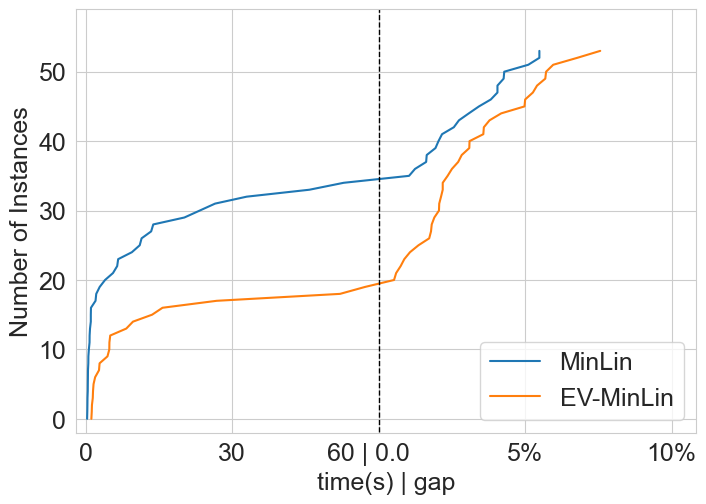

In [43]:
def mlp_performance(df,instance):

    if len(df) == 0:
        return
    
    df2 = df.copy()

    # Step 1: Group the dataframe by 'name'
    grouped = df2.groupby('name')

    # Step 2: Calculate the maximum value of 'runtime' and 'POruntime' for each group
    max_values = grouped[['timegap']].max().reset_index()

    # Step 3: Filter the groups where both maximum values are smaller than 1.0
    names_to_remove = max_values[(max_values['timegap'] < 1.0)]['name'].tolist()

    df2 = df2[~df2['name'].isin(names_to_remove)]

    print("Number of nontrivial instances: ",len(df2)/2)

    algorithms =  ["GUROBI11","Julia"]
    for alg in algorithms:
        mlp = sorted(df2[df2["solver"]==alg]["timegap"].to_list(),reverse=False) 
        n_instances = len(mlp)
        y = [x for x in range(len(mlp))]
        plt.xticks([0,30,60,90,120],["0","30","60 | 0.0   ","5%","10%"])
        plt.xlim([-2,125])
        plt.ylim([-2,n_instances+5])
        plt.plot(mlp,y,label=alg)

    plt.legend(["MinLin","EV-MinLin"],loc='lower right')
    plt.ylabel('Number of Instances')
    plt.plot([60,60], [-5,n_instances+5], 'k--', lw=1)
    plt.xlabel("time(s) | gap")
    plt.savefig("../results/MinLinTimeComparison_"+instance+".png",bbox_inches="tight")
    plt.show()


instance_types = ["mult_d_4"]
for instance in instance_types:
    mlp_performance(df[df["type"]==instance],instance)

## Autocorr Instances

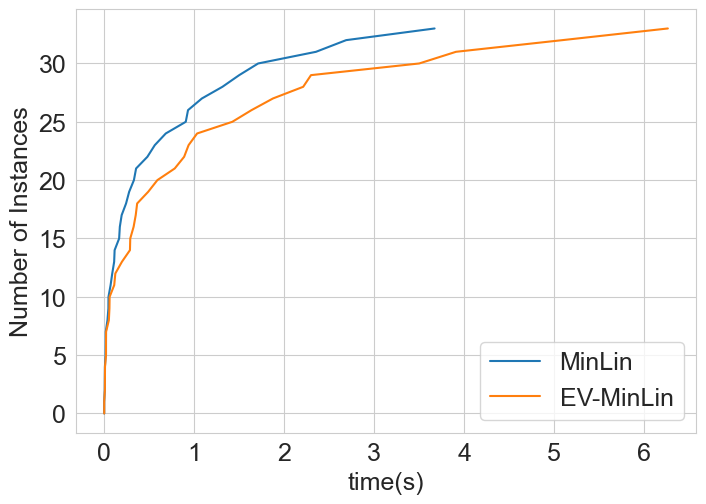

In [44]:
def mlp_performance(df,instance):

    if len(df) == 0:
        return

    algorithms =  ["GUROBI11","Julia"]
    for alg in algorithms:

        mlp = sorted(df[df["solver"]==alg]["timegap"].to_list(),reverse=False) 
        y = [x for x in range(len(mlp))]
        plt.plot(mlp,y,label=alg)

    plt.legend(["MinLin","EV-MinLin"],loc='lower right')
    plt.ylabel('Number of Instances')
    plt.xlabel("time(s)")
    plt.savefig("../results/MinLinTimeComparison_"+instance+".png",bbox_inches="tight")
    plt.show()

instance_types = ["autocorr"]
for instance in instance_types:
    mlp_performance(df[df["type"]==instance],instance)

# Section 5.5 - BB vs EV-BB

In [84]:
# Connect to the SQLite database
conn = sqlite3.connect('../results/experiments.db')

# Define your SQL query with JOIN and WHERE clauses
sql_query = """
    SELECT Instance.*, BaseLinearization.linearization, BBLinearization.warm_start, BBLinearization.runtime, BBLinearization.gap, BBLinearization.solver, BBLinearization.lin_size  
    FROM BBLinearization
    JOIN BaseLinearization ON BBLinearization.id = BaseLinearization.id 
    JOIN Instance ON BaseLinearization.instance_id = Instance.id
"""

# Execute the SQL query with parameters and load the result into a pandas DataFrame
df = pd.read_sql_query(sql_query, conn)
# Remove rows where column warm_start is equal to 0
df = df[df['warm_start'] != 1]    
del df['warm_start']


# Keep only instances where the linearization sizes are the same
df = df.groupby('name').filter(lambda group: group['lin_size'].nunique() == 1)


df["timegap"] = np.where(df["runtime"] <= 600,df["runtime"],600*(1 + df["gap"]))
conn.close()

## Mult3

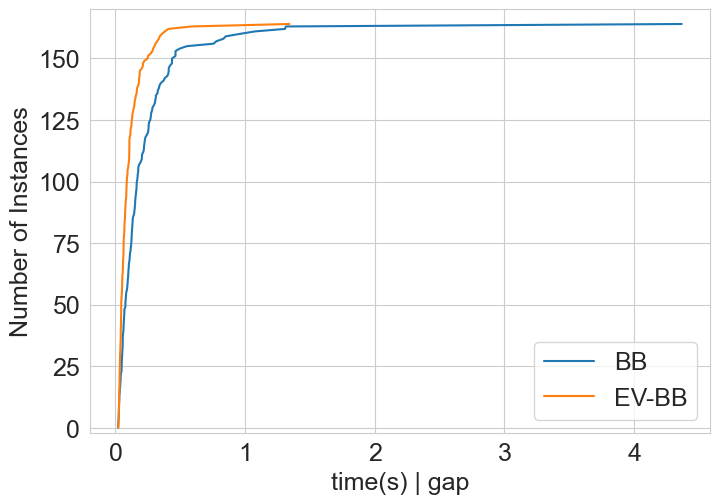

In [85]:
def mlp_performance(df,instance):

    if len(df) == 0:
        return

    algorithms =  ["GUROBI11","Julia"]
    for alg in algorithms:

        mlp = sorted(df[df["solver"]==alg]["timegap"].to_list(),reverse=False) 
        mlp = [x for x in mlp if str(x) != 'nan']
        mlp = sorted(mlp)
        n_instances = len(mlp)
        y = [x for x in range(len(mlp))]

        plt.ylim([-2,n_instances+5])
        plt.plot(mlp,y,label=alg)

    plt.legend(["BB","EV-BB"],loc='lower right')
    plt.ylabel('Number of Instances')
    plt.xlabel("time(s) | gap")
    plt.savefig("../results/BestBoundComparison_"+instance+".png",bbox_inches="tight")
    plt.show()


instance_types = ["mult_d_3"]
for instance in instance_types:
    mlp_performance(df[df["type"]==instance],instance)

## Vision

Number of nontrivial instances for vision 45.0


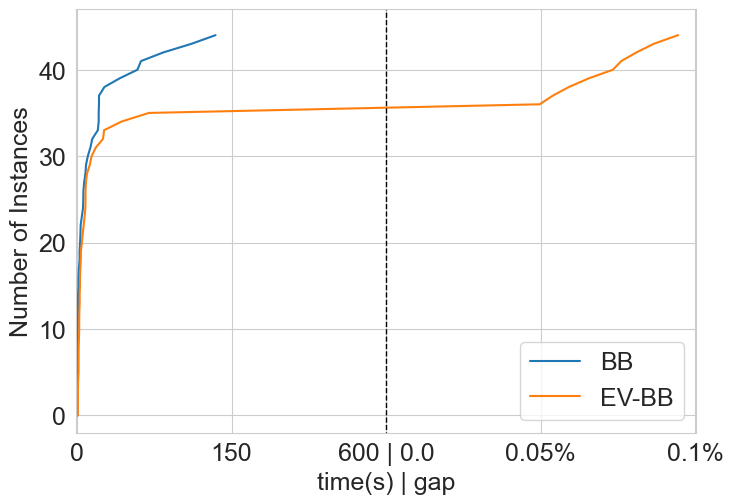

In [87]:
def mlp_performance(df,instance):

    if len(df) == 0:
        return
    
    df2 = df.copy()

    # Step 1: Group the dataframe by 'name'
    grouped = df2.groupby('name')

    # Step 2: Calculate the maximum value of 'runtime' and 'POruntime' for each group
    max_values = grouped[['timegap']].max().reset_index()

    # Step 3: Filter the groups where both maximum values are smaller than 1.0
    names_to_remove = max_values[(max_values['timegap'] < 1.0)]['name'].tolist()

    df2 = df2[~df2['name'].isin(names_to_remove)]

    df2["timegap2"] = np.where(df2["runtime"] <= 600,df2["runtime"],600*(1 + 1000*df2["gap"]))

    print("Number of nontrivial instances for",instance,len(df2)/2)


    algorithms =  ["GUROBI11","Julia"]
    for alg in algorithms:

        mlp = sorted(df2[df2["solver"]==alg]["timegap2"].to_list(),reverse=False) 
        mlp = [x for x in mlp if str(x) != 'nan']
        mlp = sorted(mlp)
        n_instances = len(mlp)
        y = [x for x in range(len(mlp))]

        plt.xticks([0,300,600,900,1200],["0", str(300//2), str(600) + " | 0.0","0.05%","0.1%"])
        plt.xlim([-2,1202])
        plt.ylim([-2,n_instances+2])
        plt.plot(mlp,y,label=alg)

    plt.legend(["BB","EV-BB"],loc='lower right')
    plt.ylabel('Number of Instances')
    plt.plot([600,600], [-5,n_instances+2], 'k--', lw=1)
    plt.xlabel("time(s) | gap")
    plt.savefig("../results/BestBoundComparison_"+instance+".png",bbox_inches="tight")
    plt.show()


instance_types = ['vision']
for instance in instance_types:
    mlp_performance(df[df["type"]==instance],instance)

## Autocorr and Mult4

Number of nontrivial instances for mult_d_4 127.0


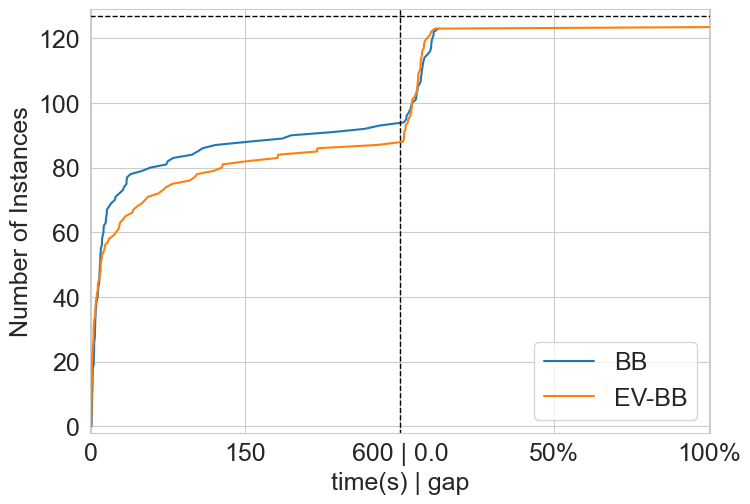

Number of nontrivial instances for autocorr 32.0


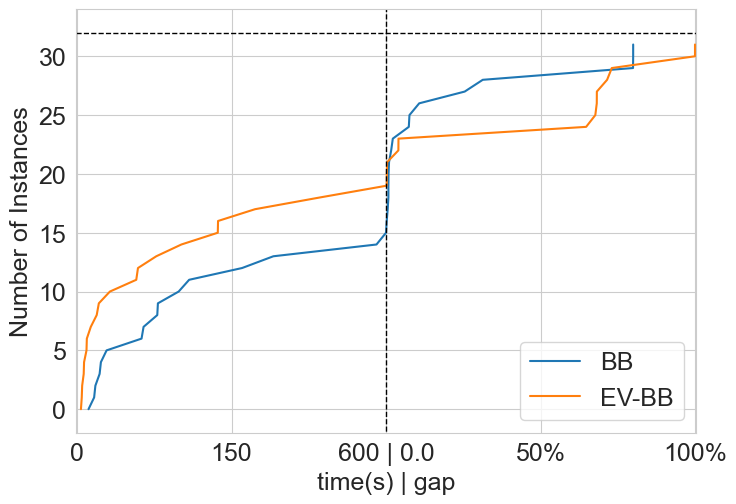

In [88]:
def mlp_performance(df,instance):

    if len(df) == 0:
        return

    df2 = df.copy()

    # Step 1: Group the dataframe by 'name'
    grouped = df2.groupby('name')

    # Step 2: Calculate the maximum value of 'runtime' and 'POruntime' for each group
    max_values = grouped[['timegap']].max().reset_index()

    # Step 3: Filter the groups where both maximum values are smaller than 1.0
    names_to_remove = max_values[(max_values['timegap'] < 1.0)]['name'].tolist()

    df2 = df2[~df2['name'].isin(names_to_remove)]

    print("Number of nontrivial instances for",instance,len(df2)/2)
    

    algorithms =  ["GUROBI11","Julia"]
    for alg in algorithms:

        mlp = sorted(df2[df2["solver"]==alg]["timegap"].to_list(),reverse=False) 
        mlp = [x for x in mlp if str(x) != 'nan']
        mlp = sorted(mlp)
        n_instances = len(mlp)
        y = [x for x in range(len(mlp))]

        plt.xticks([0,300,600,900,1200],["0", str(300//2), str(600) + " | 0.0","50%","100%"])
        plt.xlim([-2,1202])
        plt.ylim([-2,n_instances+2])
        plt.plot(mlp,y,label=alg)

    plt.legend(["BB","EV-BB"],loc='lower right')
    plt.ylabel('Number of Instances')
    plt.plot([600,600], [-5,n_instances+2], 'k--', lw=1)

    # Draw a horizontal line at n_instances
    plt.axhline(y=len(df2)/2, color='black', lw=1, linestyle='--')

    plt.xlabel("time(s) | gap")
    plt.savefig("../results/BestBoundComparison_"+instance+".png",bbox_inches="tight")
    plt.show()


instance_types = ["mult_d_4", 'autocorr']
for instance in instance_types:
    mlp_performance(df[df["type"]==instance],instance)

# Section 5.6

In [74]:
# Connect to the SQLite database
conn = sqlite3.connect('../results/experiments.db')

# Define your SQL query with JOIN and WHERE clauses
sql_query = """
    SELECT Instance.*, QCPG11.solver,  QCPG11.gap, PO.gap as POgap, QCPG11.objective, QCPG11.runtime, PO.runtime as POruntime,   BaseLinearization.linearization, BBLinearization.warm_start as BBWarm, MinLinearization.warm_start as MinLinWarm
    FROM QCPG11
    JOIN BaseLinearization ON QCPG11.id = BaseLinearization.id
    JOIN Instance ON BaseLinearization.instance_id = Instance.id
    LEFT JOIN PO ON PO.id = Instance.id
    LEFT JOIN MinLinearization ON MinLinearization.id = BaseLinearization.id
    LEFT JOIN BBLinearization ON BBLinearization.id = BaseLinearization.id
"""

# Execute the SQL query with parameters and load the result into a pandas DataFrame
df = pd.read_sql_query(sql_query, conn)

# Define your SQL query with JOIN and WHERE clauses
sql_query = """
    SELECT Instance.*,  PO.gap, PO.runtime
    FROM PO
    JOIN Instance ON PO.id = Instance.id
"""

# Execute the SQL query with parameters and load the result into a pandas DataFrame
df2 = pd.read_sql_query(sql_query, conn)
df2["linearization"] = "PO"

# Keep only instances that have been solved by all algorithms
df2_filtered = df2[df2['name'].isin(df['name'])]
df = pd.concat([df, df2], ignore_index=True)

df["timegap"] = np.where(df["runtime"] <= 600,df["runtime"],600*(1 + df["gap"]))

# Step 1: Group the dataframe by 'name'
grouped = df.groupby('name')

# Step 2: Calculate the maximum value of 'runtime' and 'POruntime' for each group
max_values = grouped[['runtime', 'POruntime']].max().reset_index()

# Step 3: Filter the groups where both maximum values are smaller than 1.0
names_to_remove = max_values[(max_values['runtime'] < 1.0) & (max_values['POruntime'] < 1.0)]['name'].tolist()

df = df[~df['name'].isin(names_to_remove)]

conn.close()

## Runtimes only (vision, mult_3)

mult_d_3 Number of nontrivial instances:  42


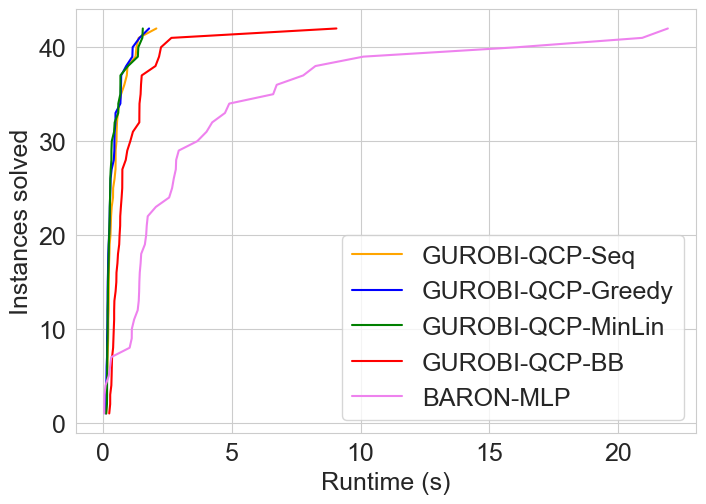

vision Number of nontrivial instances:  41


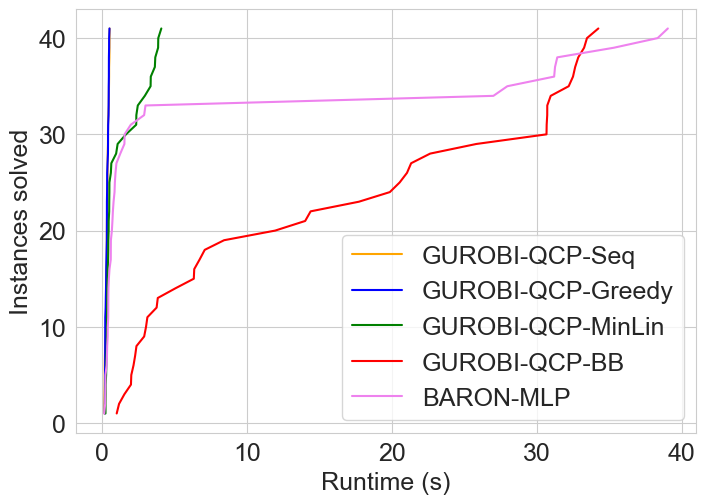

In [75]:
def qcp_time(df,instance):

    if len(df) == 0:
        return
    
    legends = list()
    n_instances = 0

    algs =  ["sequential","greedy","minlin","bestbnd","PO"]
    color_map = {'sequential': 'orange', 'greedy': 'blue', 'minlin': 'green', 'bestbnd':'red', 'PO':'violet' }  

    print(instance,"Number of nontrivial instances: ",len(sorted(df[df["linearization"]=="sequential"]["runtime"].to_list())))


    for alg in algs:
        values = sorted(df[df["linearization"]==alg]["runtime"].to_list(),reverse=False) 
        legends.append(alg)
        base = range(1,len(values)+1)
        plt.plot(values,base,c=color_map[alg])
        

    plt.ylabel("Instances solved")
    plt.xlabel("Runtime (s)")
    plt.gray()
    plt.legend(["GUROBI-QCP-Seq","GUROBI-QCP-Greedy","GUROBI-QCP-MinLin", "GUROBI-QCP-BB", "BARON-MLP"],loc='lower right')
    plt.savefig("../results/QCP_performance_"+instance+".png",bbox_inches="tight")
    plt.show()
    
instance_types = ["mult_d_3",'vision']
for instance in instance_types:
    qcp_time(df[df["type"]==instance],instance)

## Gaps only (autocorr, mult_4)

mult_d_4 Number of nontrivial instances:  143


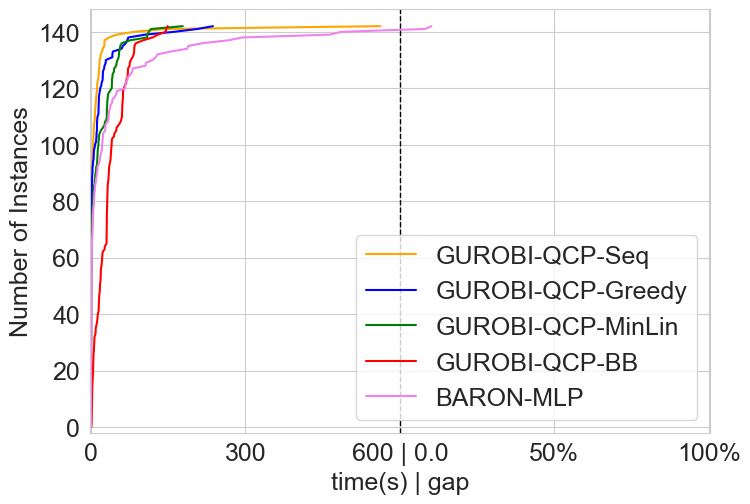

In [76]:
def qcp_time(df,instance):

    if len(df) == 0:
        return

    algorithms = ["sequential","greedy","minlin","bestbnd","PO"]
    n_instances = 0

    color_map = {'sequential': 'orange', 'greedy': 'blue', 'minlin': 'green', 'bestbnd':'red', 'PO':'violet' }  
    label_map = {'sequential': 'GUROBI-QCP-Seq', 'greedy': 'GUROBI-QCP-Greedy', 'minlin': 'GUROBI-QCP-MinLin', 'bestbnd':'GUROBI-QCP-BB', 'PO':'BARON-MLP' }  

    print(instance,"Number of nontrivial instances: ",len(sorted(df[df["linearization"]=="sequential"]["runtime"].to_list())))


    for alg in algorithms:

        mlp = sorted(df[ (df["linearization"]==alg) & (df["timegap"] <= 1200+1)   ]["timegap"].dropna().to_list(),reverse=False) 
        n_instances = max(n_instances,len(mlp))
        y = [x for x in range(len(mlp))]

        plt.xticks([0,300,600,900,1200],["0", "300", "600" + " | 0.0","50%","100%"])
        plt.xlim([-2,1200 + 2])
        plt.ylim([-2,n_instances+5])
        plt.plot(mlp,y,label=label_map[alg],c=color_map[alg])

    plt.legend(["GUROBI-QCP-Seq","GUROBI-QCP-Greedy","GUROBI-QCP-MinLin", "GUROBI-QCP-BB", "BARON-MLP"],loc='lower right')
    plt.ylabel('Number of Instances')
    plt.plot([600,600], [-2,n_instances+5], '--', lw=1, color='black')
    plt.xlabel("time(s) | gap")
    plt.savefig("../results/QCP_performance_"+instance+".png",bbox_inches="tight")
    plt.show()

    
instance_types = ["mult_d_4"]
for instance in instance_types:
    qcp_time(df[df["type"]==instance],instance)

autocorr Number of nontrivial instances:  32


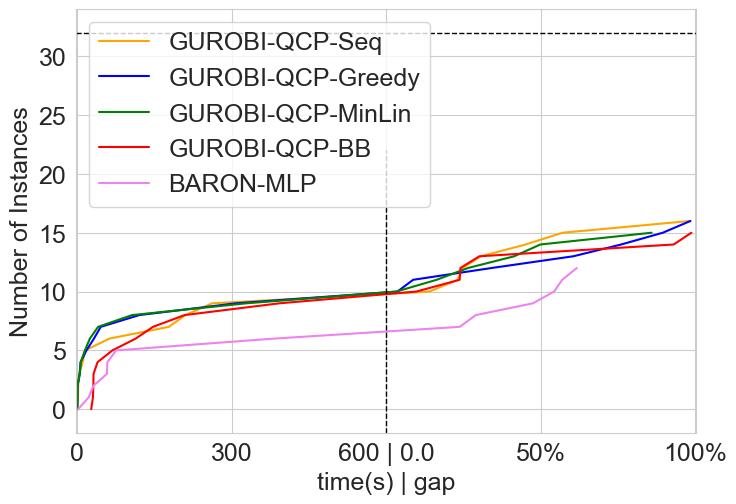

In [83]:
def qcp_time(df,instance):

    if len(df) == 0:
        return

    algorithms = ["sequential","greedy","minlin","bestbnd","PO"]
    color_map = {'sequential': 'orange', 'greedy': 'blue', 'minlin': 'green', 'bestbnd':'red', 'PO':'violet' }  
    label_map = {'sequential': 'GUROBI-QCP-Seq', 'greedy': 'GUROBI-QCP-Greedy', 'minlin': 'GUROBI-QCP-MinLin', 'bestbnd':'GUROBI-QCP-BB', 'PO':'BARON-MLP' }  

    total_instances = len(sorted(df[df["linearization"]=="sequential"]["runtime"].to_list()))
    print(instance,"Number of nontrivial instances: ",total_instances)
    n_instances = 0


    for alg in algorithms:

        mlp = sorted(df[ (df["linearization"]==alg) & (df["timegap"] <= 1200+1)   ]["timegap"].dropna().to_list(),reverse=False) 
        n_instances = max(n_instances,len(mlp))
        y = [x for x in range(len(mlp))]

        plt.xticks([0,300,600,900,1200],["0", "300", "600" + " | 0.0","50%","100%"])
        plt.xlim([-2,1200 + 2])
        plt.ylim([-2,n_instances+5])
        plt.plot(mlp,y,label=label_map[alg],c=color_map[alg])

    plt.legend(["GUROBI-QCP-Seq","GUROBI-QCP-Greedy","GUROBI-QCP-MinLin", "GUROBI-QCP-BB", "BARON-MLP"],loc='upper left')
    plt.ylabel('Number of Instances')
    plt.ylim([-2,total_instances+2])
    plt.plot([600,600], [-2,n_instances+5], '--', lw=1, color='black')
    plt.xlabel("time(s) | gap")

    # Draw a horizontal line at n_instances
    plt.axhline(y=total_instances, color='black', lw=1, linestyle='--')

    plt.savefig("../results/QCP_performance_"+instance+".png",bbox_inches="tight")
    plt.show()

    
instance_types = ["autocorr"]
for instance in instance_types:
    qcp_time(df[df["type"]==instance],instance)

## Scatterplot - MinLin

Number of nontrivial instances:  258


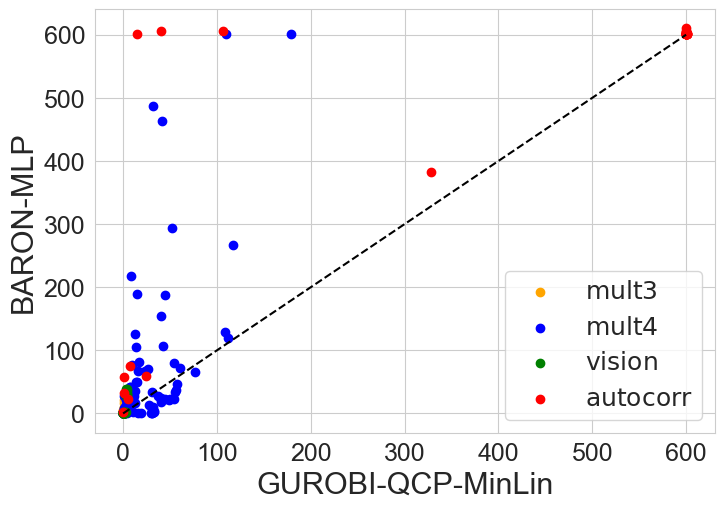

In [33]:
df2 = df[df["linearization"] == "minlin"]

# Create a color map
color_map = {'mult_d_3': 'orange', 'mult_d_4': 'blue', 'vision': 'green', 'autocorr':'red' }  # Add more if needed
name_map = {'mult_d_3': r'$\text{mult3}$', 'mult_d_4': r'$\text{mult4}$', 'vision': r'$\text{vision}$', 'autocorr':r'$\text{autocorr}$' }  # Add more if needed

# Map the 'type' column to the color map
colors = df2['type'].map(color_map)

print("Number of nontrivial instances: ",df2.shape[0])


# Loop over each type
for t in color_map:
    # Select rows of df where type is t
    df_t = df2[df2['type'] == t]
    # Plot these rows with the color corresponding to t
    plt.scatter(df_t['runtime'], df_t['POruntime'], c=color_map[t], label=name_map[t])


# Assuming df is your DataFrame
plt.xlabel('GUROBI-QCP-MinLin', fontsize=22)
plt.ylabel('BARON-MLP', fontsize=22)

min_val = 0
max_val = 600
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# Add a legend
plt.legend()

plt.savefig("../results/ScatterMinLin.png",bbox_inches="tight")
plt.show()

## Scatterplot - Best Bound

Number of nontrivial instances:  258


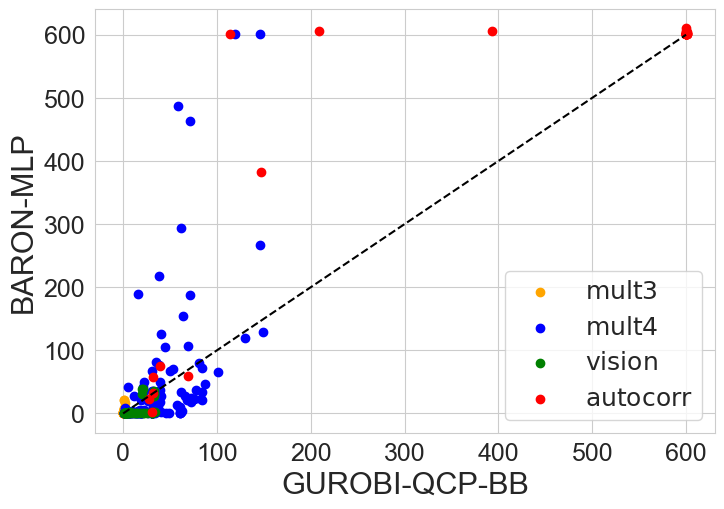

In [34]:
df2 = df[df["linearization"] == "bestbnd"]

# Create a color map
color_map = {'mult_d_3': 'orange', 'mult_d_4': 'blue', 'vision': 'green', 'autocorr':'red' }  # Add more if needed
name_map = {'mult_d_3': r'$\text{mult3}$', 'mult_d_4': r'$\text{mult4}$', 'vision': r'$\text{vision}$', 'autocorr':r'$\text{autocorr}$' }  # Add more if needed

# Map the 'type' column to the color map
colors = df2['type'].map(color_map)

print("Number of nontrivial instances: ",df2.shape[0])

# Loop over each type
for t in color_map:
    # Select rows of df where type is t
    df_t = df2[df2['type'] == t]
    # Plot these rows with the color corresponding to t
    plt.scatter(df_t['runtime'], df_t['POruntime'], c=color_map[t], label=name_map[t])


# Assuming df is your DataFrame
plt.xlabel('GUROBI-QCP-BB', fontsize=22)
plt.ylabel('BARON-MLP', fontsize=22)

min_val = 0
max_val = 600
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# Add a legend
plt.legend()
plt.savefig("../results/ScatterBB.png",bbox_inches="tight")
plt.show()